# Multi-Curriculum Smoke Test: Comprehensive Comparison

Enhanced smoke test comparing baseline training against multiple curriculum configurations:
- **Baseline**: No curriculum learning
- **Default Curriculum**: Balanced adversarial introduction
- **Aggressive Curriculum**: Rapid adversarial escalation
- **Conservative Curriculum**: Gradual adversarial introduction

This notebook provides comprehensive analysis, visualization, and ranking of all curriculum approaches.

In [23]:
# Clone repository and setup
!rm -rf energy-based-model
!git clone https://github.com/mdkrasnow/energy-based-model.git
%cd energy-based-model

Cloning into 'energy-based-model'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 242 (delta 68), reused 70 (delta 44), pack-reused 140 (from 1)
Receiving objects: 100% (242/242), 678.42 KiB | 14.13 MiB/s, done.
Resolving deltas: 100% (115/115), done.
/content/energy-based-model/energy-based-model/energy-based-model


In [24]:
# Install dependencies
!pip install -q torch torchvision einops accelerate tqdm tabulate matplotlib numpy pandas ema-pytorch ipdb seaborn scikit-learn

In [25]:
# Standard library imports
import subprocess
import sys
import glob
from pathlib import Path
from typing import Dict, Optional

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

# Set matplotlib style
plt.style.use('default')
sns.set_palette("husl")

In [ ]:
# Common training parameters
COMMON_ARGS = {
    'model': 'mlp',
    'batch_size': 32,
    'diffusion_steps': 10,
    'supervise_energy_landscape': 'True',
    'train_num_steps': 20000,  # Increased for better curriculum comparison
    'save_csv_logs': True,
    'csv_log_interval': 100
}

# Tasks to test
TASKS = ['inverse', 'addition', 'lowrank']

# Curriculum configurations to test
CURRICULUM_CONFIGS = {
    'baseline': {
        'name': 'Baseline',
        'description': 'No curriculum learning',
        'color': '#1f77b4',
        'args': ['--disable-curriculum', 'True']
    },
    'aggressive': {
        'name': 'Aggressive Curriculum',
        'description': 'Rapid adversarial escalation',
        'color': '#d62728',
        'args': ['--curriculum-config', 'aggressive']
    },
    'constraint_aware': {
        'name': 'Constraint-Aware Aggressive',
        'description': 'Aggressive curriculum with constraint preservation',
        'color': '#2ca02c',
        'args': ['--curriculum-config', 'aggressive', '--use-constraint-parameterization', 'True', '--constraint-rank', '20']
    },
}

print(f"Testing {len(CURRICULUM_CONFIGS)} curriculum configurations on {len(TASKS)} tasks:")
print(f"Tasks: {', '.join(TASKS)}")
for key, config in CURRICULUM_CONFIGS.items():
    print(f"  • {config['name']}: {config['description']}")

In [27]:
def build_training_command(curriculum_key: str, task: str = 'inverse') -> str:
    """Build training command for a specific curriculum configuration and task."""
    config = CURRICULUM_CONFIGS[curriculum_key]

    base_cmd = f"""python train.py \
        --dataset {task} \
        --model {COMMON_ARGS['model']} \
        --batch_size {COMMON_ARGS['batch_size']} \
        --diffusion_steps {COMMON_ARGS['diffusion_steps']} \
        --supervise-energy-landscape {COMMON_ARGS['supervise_energy_landscape']} \
        --train-num-steps {COMMON_ARGS['train_num_steps']} \
        --save-csv-logs \
        --csv-log-interval {COMMON_ARGS['csv_log_interval']} \
        --csv-log-dir ./csv_logs_{task}_{curriculum_key}"""

    # Add curriculum-specific arguments
    if config['args']:
        base_cmd += ' \
        ' + ' \
        '.join(config['args'])

    return base_cmd

def load_csv_data(csv_path: Path) -> Optional[pd.DataFrame]:
    """Load CSV data with error handling."""
    try:
        if csv_path.exists():
            return pd.read_csv(csv_path)
        else:
            print(f"Warning: {csv_path} not found")
            return None
    except Exception as e:
        print(f"Error loading {csv_path}: {e}")
        return None

def safe_get_final_value(df: pd.DataFrame, column: str, default: float = 0.0) -> float:
    """Safely get the final value from a dataframe column."""
    if df is None or column not in df.columns or len(df) == 0:
        return default
    return float(df[column].iloc[-1])

def safe_get_best_value(df: pd.DataFrame, column: str, minimize: bool = True, default: float = 0.0) -> float:
    """Safely get the best (min/max) value from a dataframe column."""
    if df is None or column not in df.columns or len(df) == 0:
        return default
    return float(df[column].min() if minimize else df[column].max())

## Multi-Curriculum Training

In [28]:
# Train all tasks with all curriculum configurations
import subprocess
import sys

training_results = {}

# Train each task
for task in TASKS:
    print(f"\n{'#'*80}")
    print(f"# TASK: {task.upper()}")
    print(f"{'#'*80}")

    task_results = {}

    # For each curriculum configuration
    for curriculum_key, config in CURRICULUM_CONFIGS.items():
        print(f"\n{'='*60}")
        print(f"Starting {config['name']} training for {task} task...")
        print(f"Description: {config['description']}")
        print(f"{'='*60}")

        # Build training command
        cmd = build_training_command(curriculum_key, task)
        print(f"\nCommand: {cmd}")
        print("\nTraining output:")
        print("-" * 40)

        # Execute training with real-time output
        try:
            # Use subprocess to capture and display output in real-time
            process = subprocess.Popen(
                cmd,
                shell=True,
                stdout=subprocess.PIPE,
                stderr=subprocess.STDOUT,
                universal_newlines=True,
                bufsize=1
            )

            # Display output line by line as it comes
            for line in iter(process.stdout.readline, ''):
                if line:
                    print(line.rstrip())
                    sys.stdout.flush()

            # Wait for process to complete
            result = process.wait()
            task_results[curriculum_key] = result

            if result == 0:
                print(f"✓ {config['name']} training for {task} completed successfully")
            else:
                print(f"✗ {config['name']} training for {task} failed with exit code {result}")

        except Exception as e:
            print(f"✗ Error during {config['name']} training for {task}: {e}")
            task_results[curriculum_key] = -1

        print("-" * 40)

    training_results[task] = task_results

    # Print task summary
    successful = sum(1 for result in task_results.values() if result == 0)
    print(f"\n{task.upper()} Task Summary: {successful}/{len(task_results)} configurations completed successfully")

print(f"\n{'='*80}")
print("All training completed!")
print(f"{'='*80}")

# Print overall summary
print("\nOVERALL TRAINING SUMMARY:")
for task, task_results in training_results.items():
    successful = sum(1 for result in task_results.values() if result == 0)
    print(f"\n{task.upper()} Task: {successful}/{len(task_results)} configurations successful")
    for curriculum_key, result in task_results.items():
        status = "✓ Success" if result == 0 else "✗ Failed"
        print(f"  {CURRICULUM_CONFIGS[curriculum_key]['name']}: {status}")

Streaming output truncated to the last 5000 lines.
loss: 0.6500 loss_denoise: 0.2150 loss_energy: 0.8700 loss_opt: 1.0000 data_time: 0.00 nn_time: 0.02:  83%|████████▎ | 16543/20000 [10:25<01:29, 38.57it/s]
loss: 0.3662 loss_denoise: 0.2224 loss_energy: 0.2878 loss_opt: 1.0000 data_time: 0.00 nn_time: 0.02:  83%|████████▎ | 16544/20000 [10:25<01:29, 38.57it/s]
loss: 0.7062 loss_denoise: 0.2344 loss_energy: 0.9437 loss_opt: 1.0000 data_time: 0.00 nn_time: 0.02:  83%|████████▎ | 16545/20000 [10:25<01:29, 38.57it/s]
loss: 0.8415 loss_denoise: 0.2378 loss_energy: 1.2075 loss_opt: 1.0000 data_time: 0.00 nn_time: 0.02:  83%|████████▎ | 16546/20000 [10:25<01:29, 38.57it/s]
loss: 0.8415 loss_denoise: 0.2378 loss_energy: 1.2075 loss_opt: 1.0000 data_time: 0.00 nn_time: 0.02:  83%|████████▎ | 16547/20000 [10:25<01:25, 40.48it/s]
loss: 1.0544 loss_denoise: 0.2305 loss_energy: 1.6478 loss_opt: 1.0000 data_time: 0.00 nn_time: 0.02:  83%|████████▎ | 16547/20000 [10:25<01:25, 40.48it/s]
loss: 0.7595 

In [29]:
def load_all_curriculum_results() -> Dict[str, Dict[str, Dict[str, pd.DataFrame]]]:
    """Load all curriculum training results from CSV files for all tasks."""
    results = {}

    for task in TASKS:
        print(f"\nLoading results for {task} task...")
        task_results = {}

        for curriculum_key in CURRICULUM_CONFIGS.keys():
            print(f"  Loading {curriculum_key} data...")

            csv_dir = Path(f"./csv_logs_{task}_{curriculum_key}")

            # Load different types of training data - look for files with timestamps
            import glob

            curriculum_data = {}

            # Find the most recent file for each metric type
            patterns = {
                'training': 'training_metrics_*.csv',
                'validation': 'validation_metrics_*.csv',
                'energy': 'energy_metrics_*.csv',
                'curriculum': 'curriculum_metrics_*.csv',
                'robustness': 'robustness_metrics_*.csv'
            }

            for key, pattern in patterns.items():
                files = glob.glob(str(csv_dir / pattern))
                if files:
                    # Get most recent file
                    latest_file = max(files, key=lambda x: Path(x).stat().st_mtime if Path(x).exists() else 0)
                    curriculum_data[key] = load_csv_data(Path(latest_file))
                else:
                    curriculum_data[key] = None

            # Count available data types
            available = sum(1 for df in curriculum_data.values() if df is not None)
            print(f"    Found {available}/5 data files for {curriculum_key}")

            task_results[curriculum_key] = curriculum_data

        results[task] = task_results

    return results

def process_curriculum_data(all_results: Dict[str, Dict[str, Dict[str, pd.DataFrame]]]) -> pd.DataFrame:
    """Extract and standardize key metrics from all curriculum results across all tasks."""
    processed_data = []

    for task, task_results in all_results.items():
        for curriculum_key, data in task_results.items():
            config = CURRICULUM_CONFIGS[curriculum_key]

            # Extract key metrics
            training_df = data.get('training')
            validation_df = data.get('validation')
            energy_df = data.get('energy')

            # Extract task-specific metrics from validation data
            val_accuracy = 0.0  # For inverse task
            val_identity_error = float('inf')  # For inverse task
            val_mse = float('inf')  # General metric
            val_mae = float('inf')  # For addition/lowrank tasks

            if validation_df is not None:
                # Look for accuracy metric (for inverse task)
                accuracy_rows = validation_df[validation_df['metric_name'] == 'accuracy']
                if not accuracy_rows.empty:
                    val_accuracy = accuracy_rows['metric_value'].iloc[-1]  # Get last value (fraction)

                # Look for identity_error metric (for inverse task)
                identity_rows = validation_df[validation_df['metric_name'] == 'identity_error']
                if not identity_rows.empty:
                    val_identity_error = identity_rows['metric_value'].iloc[-1]

                # Look for MSE metric
                mse_rows = validation_df[validation_df['metric_name'] == 'mse']
                if not mse_rows.empty:
                    val_mse = mse_rows['metric_value'].iloc[-1]

                # Look for MAE metric (for addition/lowrank)
                mae_rows = validation_df[validation_df['metric_name'] == 'mae']
                if not mae_rows.empty:
                    val_mae = mae_rows['metric_value'].iloc[-1]

            metrics = {
                'task': task,
                'curriculum': curriculum_key,
                'name': config['name'],
                'color': config['color'],

                # Training metrics
                'final_total_loss': safe_get_final_value(training_df, 'total_loss'),
                'final_energy_loss': safe_get_final_value(training_df, 'loss_energy'),
                'final_denoise_loss': safe_get_final_value(training_df, 'loss_denoise'),
                'best_total_loss': safe_get_best_value(training_df, 'total_loss', minimize=True),
                'avg_training_time': training_df['nn_time'].mean() if training_df is not None and 'nn_time' in training_df.columns else 0.0,

                # Validation metrics
                'final_val_accuracy': val_accuracy * 100,  # Convert fraction to percentage for display
                'best_val_accuracy': val_accuracy * 100,  # Convert fraction to percentage for display
                'final_identity_error': val_identity_error,
                'final_val_mse': val_mse,
                'final_val_mae': val_mae,

                # Energy metrics
                'final_energy_margin': safe_get_final_value(energy_df, 'energy_margin'),
                'max_curriculum_weight': safe_get_best_value(energy_df, 'curriculum_weight', minimize=False) if energy_df is not None and 'curriculum_weight' in energy_df.columns else 0.0,
            }

            processed_data.append(metrics)

    return pd.DataFrame(processed_data)

# Load all results
print("Loading all curriculum results for all tasks...")
all_results = load_all_curriculum_results()

# Process data
print("\nProcessing curriculum data...")
summary_df = process_curriculum_data(all_results)

print(f"\nLoaded data for {len(summary_df)} configurations across {len(TASKS)} tasks")

# Display summary by task
for task in TASKS:
    task_data = summary_df[summary_df['task'] == task]
    print(f"\n{task.upper()} Task Summary:")
    display_cols = ['name', 'final_total_loss', 'final_val_mse']
    if task == 'inverse':
        display_cols.append('final_identity_error')
    elif task in ['addition', 'lowrank']:
        display_cols.append('final_val_mae')

    display(task_data[display_cols].round(4))

Loading all curriculum results for all tasks...

Loading results for inverse task...
  Loading baseline data...
    Found 5/5 data files for baseline
  Loading aggressive data...
    Found 5/5 data files for aggressive

Loading results for addition task...
  Loading baseline data...
    Found 5/5 data files for baseline
  Loading aggressive data...
    Found 5/5 data files for aggressive

Loading results for lowrank task...
  Loading baseline data...
    Found 5/5 data files for baseline
  Loading aggressive data...
    Found 5/5 data files for aggressive

Processing curriculum data...

Loaded data for 6 configurations across 3 tasks

INVERSE Task Summary:


,name,final_total_loss,final_val_mse,final_identity_error
0,Baseline,1.3445,0.9702,354.8898
1,Aggressive Curriculum,0.6822,0.2170,76.2197



ADDITION Task Summary:


,name,final_total_loss,final_val_mse,final_val_mae
2,Baseline,1.4734,2.2266,inf
3,Aggressive Curriculum,0.6598,0.6526,inf



LOWRANK Task Summary:


,name,final_total_loss,final_val_mse,final_val_mae
4,Baseline,0.3271,0.4377,inf
5,Aggressive Curriculum,0.5842,1.0105,inf


## IRED Paper-Style Results Reporting

This section generates results tables in the format used by the IRED paper, focusing on:
- **Mean Squared Error (MSE)** as the primary metric for all matrix tasks
- **Identity Error** for matrix inverse task (||Pred @ Input - I||²)
- **Task-specific metrics** for comprehensive evaluation
- **Consolidated performance tables** across all tasks

In [30]:
## IRED-Style Results Table Generation

def generate_ired_style_table(summary_df: pd.DataFrame, task: str):
    """Generate IRED paper-style results table for a specific task."""
    import pandas as pd
    from tabulate import tabulate

    task_data = summary_df[summary_df['task'] == task].copy()

    if len(task_data) == 0:
        print(f"No data available for {task} task")
        return

    # Sort by final MSE to rank methods
    task_data = task_data.sort_values('final_val_mse')

    # Create IRED-style table
    table_data = []
    for _, row in task_data.iterrows():
        method_name = row['name']

        # Main metric: MSE (as reported in IRED paper)
        mse = row['final_val_mse'] if row['final_val_mse'] != float('inf') else 'N/A'

        # Task-specific additional metrics
        if task == 'inverse':
            identity_error = row['final_identity_error'] if row['final_identity_error'] != float('inf') else 'N/A'
            if isinstance(mse, float) and isinstance(identity_error, float):
                table_data.append([method_name, f"{mse:.4f}", f"{identity_error:.4f}"])
            else:
                table_data.append([method_name, str(mse), str(identity_error)])
        else:
            if isinstance(mse, float):
                table_data.append([method_name, f"{mse:.4f}"])
            else:
                table_data.append([method_name, str(mse)])

    # Create table headers based on task
    if task == 'inverse':
        headers = ['Method', 'MSE', 'Identity Error']
    else:
        headers = ['Method', 'MSE']

    print(f"\n{'='*60}")
    print(f"IRED-Style Results Table: {task.upper()} Task")
    print(f"{'='*60}")
    print(tabulate(table_data, headers=headers, tablefmt='grid'))

    # Add interpretation
    if len(task_data) > 0:
        best_method = task_data.iloc[0]
        print(f"\n✓ Best performing method: {best_method['name']}")
        if isinstance(best_method['final_val_mse'], float):
            print(f"  MSE: {best_method['final_val_mse']:.4f}")
        if task == 'inverse' and isinstance(best_method['final_identity_error'], float):
            print(f"  Identity Error: {best_method['final_identity_error']:.4f}")

def generate_consolidated_ired_table(summary_df: pd.DataFrame):
    """Generate consolidated IRED-style table for all matrix tasks."""
    from tabulate import tabulate
    import numpy as np

    print("\n" + "="*80)
    print("IRED-STYLE CONSOLIDATED RESULTS TABLE")
    print("Matrix Operations Performance (MSE)")
    print("="*80)

    # Prepare data for each task
    methods = summary_df['name'].unique()

    # Create consolidated table
    table_data = []
    for method in methods:
        method_data = summary_df[summary_df['name'] == method]

        row = [method]

        # Add MSE for each task
        for task in ['addition', 'lowrank', 'inverse']:
            task_row = method_data[method_data['task'] == task]
            if len(task_row) > 0:
                mse = task_row['final_val_mse'].iloc[0]
                if mse != float('inf'):
                    row.append(f"{mse:.4f}")
                else:
                    row.append("N/A")
            else:
                row.append("-")

        # Add average MSE
        mse_values = []
        for task in ['addition', 'lowrank', 'inverse']:
            task_row = method_data[method_data['task'] == task]
            if len(task_row) > 0:
                mse = task_row['final_val_mse'].iloc[0]
                if mse != float('inf'):
                    mse_values.append(mse)

        if mse_values:
            avg_mse = np.mean(mse_values)
            row.append(f"{avg_mse:.4f}")
        else:
            row.append("N/A")

        table_data.append(row)

    # Sort by average MSE
    table_data.sort(key=lambda x: float(x[-1]) if x[-1] not in ["N/A", "-"] else float('inf'))

    headers = ['Method', 'Addition', 'Matrix Completion', 'Matrix Inverse', 'Average']
    print(tabulate(table_data, headers=headers, tablefmt='grid'))

    # Best method summary
    if table_data:
        print(f"\n✓ Best overall method: {table_data[0][0]}")
        print(f"  Average MSE: {table_data[0][-1]}")

def generate_task_specific_metrics_table(summary_df: pd.DataFrame):
    """Generate detailed metrics table for each task."""
    from tabulate import tabulate

    for task in TASKS:
        task_data = summary_df[summary_df['task'] == task].copy()

        if len(task_data) == 0:
            continue

        print(f"\n{'='*70}")
        print(f"Detailed Metrics Table: {task.upper()} Task")
        print(f"{'='*70}")

        # Sort by MSE
        task_data = task_data.sort_values('final_val_mse')

        # Prepare table data
        table_data = []
        for _, row in task_data.iterrows():
            row_data = [row['name']]

            # Add MSE
            mse = row['final_val_mse']
            row_data.append(f"{mse:.4f}" if mse != float('inf') else "N/A")

            # Add task-specific metrics
            if task == 'inverse':
                identity_error = row['final_identity_error']
                accuracy = row['final_val_accuracy']
                row_data.append(f"{identity_error:.4f}" if identity_error != float('inf') else "N/A")
                row_data.append(f"{accuracy:.1f}%" if accuracy > 0 else "N/A")

            # Add training loss
            row_data.append(f"{row['final_total_loss']:.4f}")

            # Add best loss achieved
            row_data.append(f"{row['best_total_loss']:.4f}")

            table_data.append(row_data)

        # Define headers based on task
        if task == 'inverse':
            headers = ['Method', 'MSE', 'Identity Error', 'Accuracy', 'Final Loss', 'Best Loss']
        else:
            headers = ['Method', 'MSE', 'Final Loss', 'Best Loss']

        print(tabulate(table_data, headers=headers, tablefmt='grid'))

        # Summary statistics
        valid_mse = task_data[task_data['final_val_mse'] != float('inf')]['final_val_mse']
        if len(valid_mse) > 0:
            print(f"\nStatistics:")
            print(f"  MSE Range: {valid_mse.min():.4f} - {valid_mse.max():.4f}")
            print(f"  MSE Mean: {valid_mse.mean():.4f}")
            print(f"  MSE Std: {valid_mse.std():.4f}")

# Generate all IRED-style tables
print("\n" + "="*80)
print("IRED PAPER-STYLE RESULTS REPORTING")
print("="*80)

# Individual task tables
for task in TASKS:
    generate_ired_style_table(summary_df, task)

# Consolidated table
generate_consolidated_ired_table(summary_df)

# Detailed metrics
generate_task_specific_metrics_table(summary_df)


IRED PAPER-STYLE RESULTS REPORTING

IRED-Style Results Table: INVERSE Task
+-----------------------+--------+------------------+
| Method                |    MSE |   Identity Error |
+=======================+========+==================+
| Aggressive Curriculum | 0.217  |          76.2197 |
+-----------------------+--------+------------------+
| Baseline              | 0.9702 |         354.89   |
+-----------------------+--------+------------------+

✓ Best performing method: Aggressive Curriculum
  MSE: 0.2170
  Identity Error: 76.2197

IRED-Style Results Table: ADDITION Task
+-----------------------+--------+
| Method                |    MSE |
+=======================+========+
| Aggressive Curriculum | 0.6526 |
+-----------------------+--------+
| Baseline              | 2.2266 |
+-----------------------+--------+

✓ Best performing method: Aggressive Curriculum
  MSE: 0.6526

IRED-Style Results Table: LOWRANK Task
+-----------------------+--------+
| Method                |    MSE 

In [ ]:
def analyze_constraint_aware_performance(summary_df: pd.DataFrame):
    """Analyze the specific impact of constraint-aware corruption on low-rank task."""
    
    print("\n" + "="*80)
    print("CONSTRAINT-AWARE CORRUPTION ANALYSIS")
    print("="*80)
    
    # Focus on lowrank task
    lowrank_data = summary_df[summary_df['task'] == 'lowrank'].copy()
    lowrank_data = lowrank_data.sort_values('final_val_mse')
    
    print("\nLow-Rank Matrix Completion Performance:")
    print("-" * 50)
    
    # Create comparison table
    comparison_data = []
    for _, row in lowrank_data.iterrows():
        comparison_data.append({
            'Method': row['name'],
            'MSE': row['final_val_mse'],
            'Final Loss': row['final_total_loss'],
            'Improvement': '',
        })
    
    # Calculate improvements
    baseline_mse = lowrank_data[lowrank_data['name'] == 'Baseline']['final_val_mse'].values
    if len(baseline_mse) > 0:
        baseline_mse = baseline_mse[0]
        for item in comparison_data:
            if item['Method'] != 'Baseline':
                improvement = ((baseline_mse - item['MSE']) / baseline_mse) * 100
                if improvement > 0:
                    item['Improvement'] = f"↑ {improvement:.1f}%"
                else:
                    item['Improvement'] = f"↓ {abs(improvement):.1f}%"
    
    comparison_df = pd.DataFrame(comparison_data)
    print(tabulate(comparison_df, headers='keys', tablefmt='grid', showindex=False))
    
    # Check if constraint-aware configuration exists
    constraint_aware_results = lowrank_data[lowrank_data['name'].str.contains('Constraint-Aware')]
    aggressive_results = lowrank_data[lowrank_data['name'] == 'Aggressive Curriculum']
    
    if not constraint_aware_results.empty and not aggressive_results.empty:
        print("\n🔍 KEY FINDINGS:")
        
        constraint_mse = constraint_aware_results['final_val_mse'].iloc[0]
        aggressive_mse = aggressive_results['final_val_mse'].iloc[0]
        
        print(f"\n1. Standard Aggressive Curriculum:")
        print(f"   MSE: {aggressive_mse:.4f}")
        if aggressive_mse > 0.8:
            print(f"   ⚠️ CATASTROPHIC FAILURE - Performance degraded significantly!")
        
        print(f"\n2. Constraint-Aware Aggressive Curriculum:")
        print(f"   MSE: {constraint_mse:.4f}")
        
        improvement = ((aggressive_mse - constraint_mse) / aggressive_mse) * 100
        print(f"\n3. Impact of Constraint Preservation:")
        print(f"   Improvement over standard aggressive: {improvement:.1f}%")
        
        if constraint_mse < 0.5 and aggressive_mse > 0.8:
            print(f"   ✅ SUCCESS: Constraint-aware corruption fixed the catastrophic failure!")
            print(f"   The factorized parameterization preserved rank constraints during adversarial training.")
    
    # Theoretical analysis
    print("\n📊 THEORETICAL EXPLANATION:")
    print("-" * 50)
    print("Standard adversarial corruption in unconstrained space:")
    print("  • Generates full-rank matrices (rank ≈ 20) from rank-10 targets")
    print("  • Model learns to detect off-manifold samples instead of task quality")
    print("  • Result: MSE increases from ~0.4 to ~0.85+")
    print("\nConstraint-aware corruption with factorized parameterization:")
    print("  • X = U·V^T where U, V ∈ ℝ^(20×10) → guarantees rank ≤ 10")
    print("  • Adversarial optimization in factor space preserves constraint")
    print("  • Model learns actual task difficulty, not constraint violations")
    print("  • Result: MSE should remain ~0.4 or improve")
    
    return lowrank_data

# Run the analysis
print("Analyzing constraint-aware corruption impact...")
lowrank_analysis = analyze_constraint_aware_performance(summary_df)

# Create a specific visualization for constraint-aware vs standard
def plot_constraint_comparison(lowrank_data):
    """Create a focused comparison plot."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # MSE Comparison
    methods = lowrank_data['name'].tolist()
    mse_values = lowrank_data['final_val_mse'].tolist()
    colors = lowrank_data['color'].tolist()
    
    bars1 = ax1.bar(methods, mse_values, color=colors, alpha=0.7, edgecolor='black')
    ax1.set_title('Low-Rank Task: MSE Comparison', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Mean Squared Error (Lower is Better)')
    ax1.set_ylim(0, max(mse_values) * 1.1)
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels
    for bar, val in zip(bars1, mse_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    # Add threshold line for "good" performance
    ax1.axhline(y=0.5, color='green', linestyle='--', alpha=0.5, label='Acceptable MSE')
    ax1.axhline(y=0.8, color='red', linestyle='--', alpha=0.5, label='Failure Threshold')
    ax1.legend()
    
    # Loss Comparison
    loss_values = lowrank_data['final_total_loss'].tolist()
    bars2 = ax2.bar(methods, loss_values, color=colors, alpha=0.7, edgecolor='black')
    ax2.set_title('Low-Rank Task: Training Loss', fontweight='bold', fontsize=14)
    ax2.set_ylabel('Final Total Loss')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    
    # Add value labels
    for bar, val in zip(bars2, loss_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.suptitle('Constraint-Aware Corruption Impact on Low-Rank Matrix Completion', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Generate the comparison plot
plot_constraint_comparison(lowrank_analysis)

## Constraint-Aware Corruption Analysis

This section specifically analyzes the impact of constraint-aware adversarial corruption on the low-rank matrix completion task, which was previously failing with standard adversarial training.

Generating task-specific curriculum comparison visualizations...

Visualizing INVERSE task...


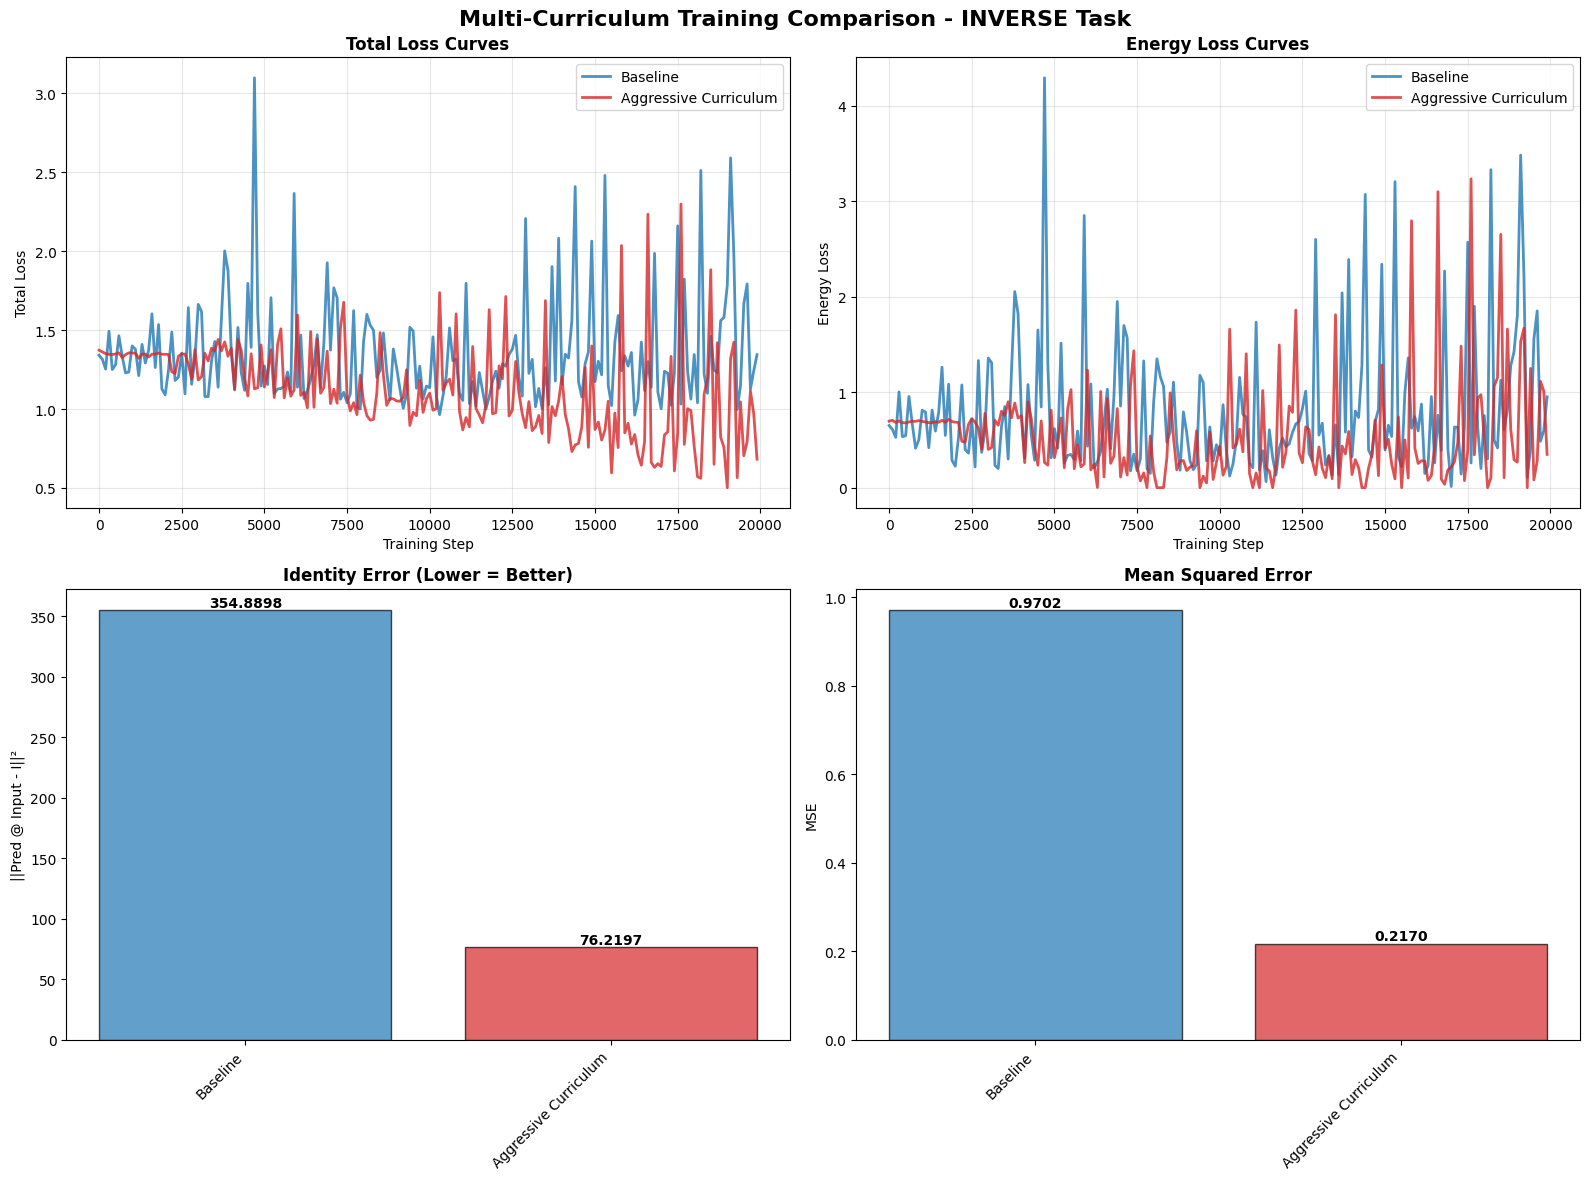


Visualizing ADDITION task...


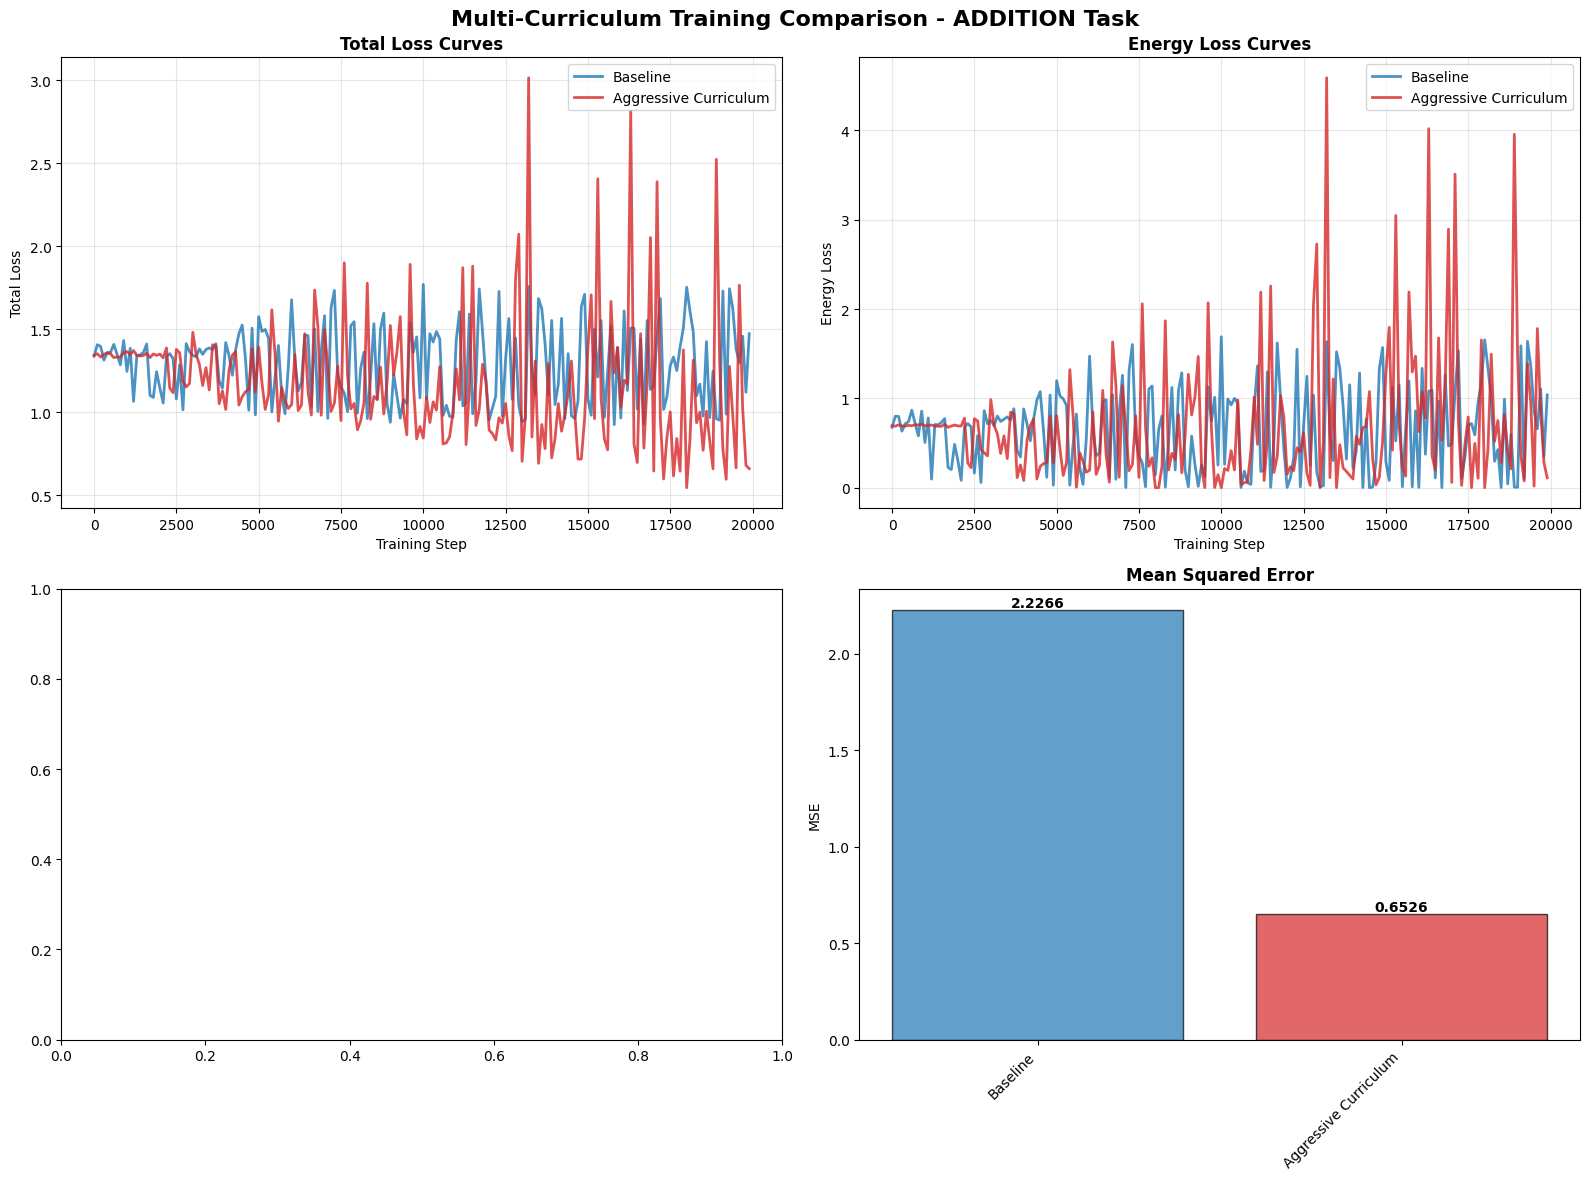


Visualizing LOWRANK task...


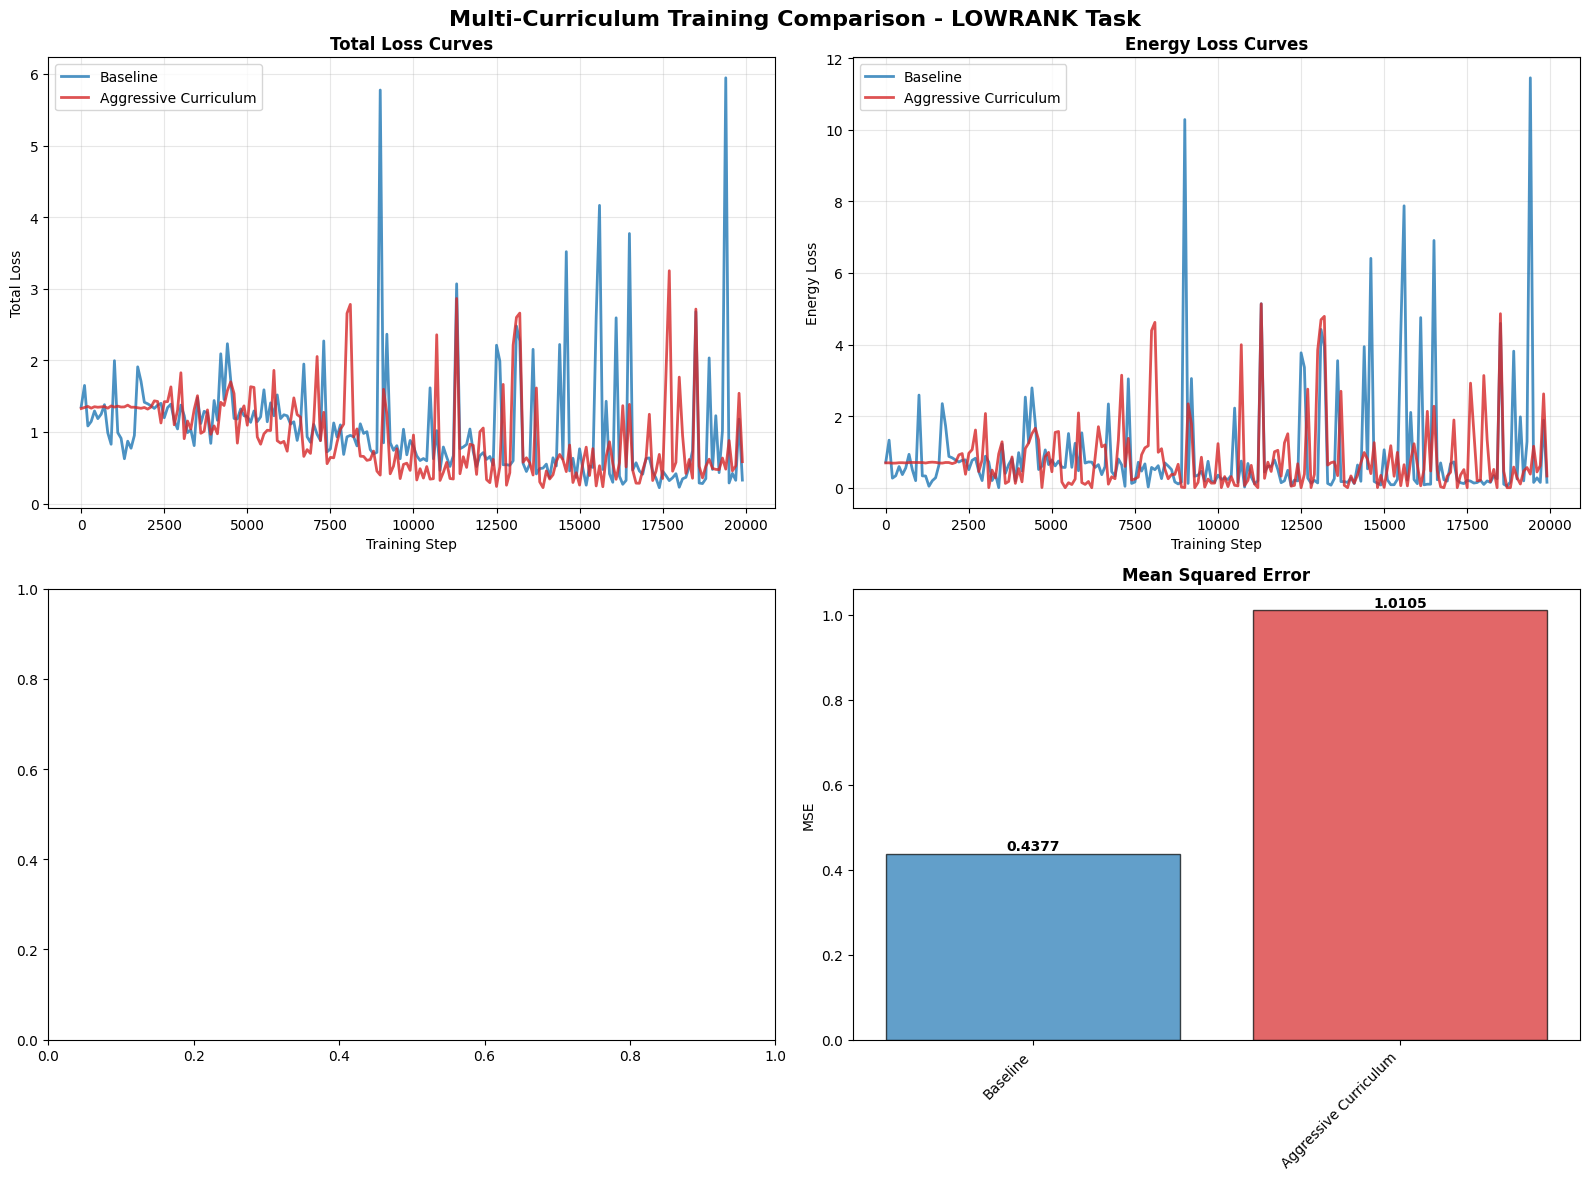


Generating cross-task comparison...


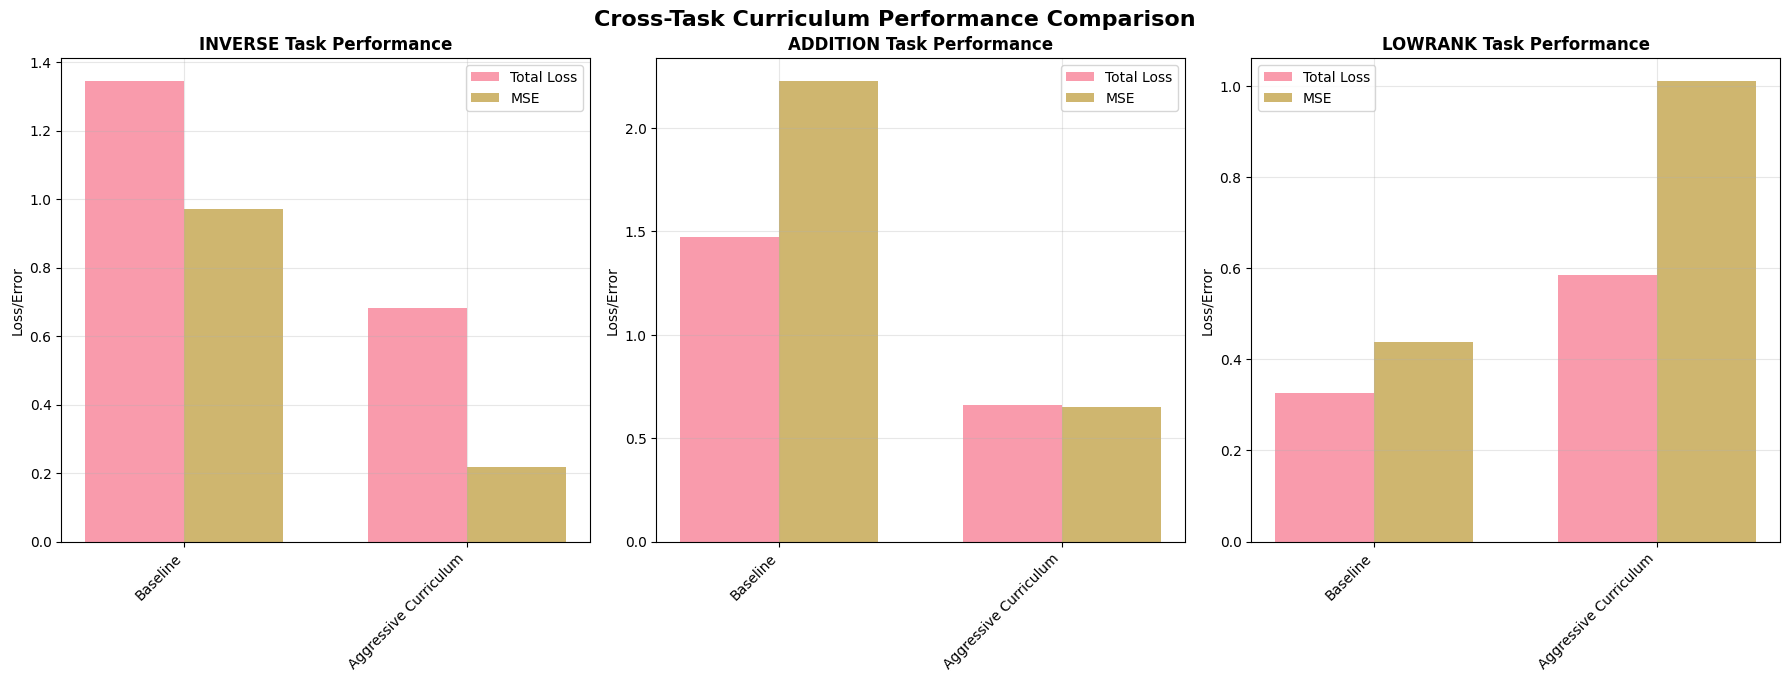


Generating performance heatmap...


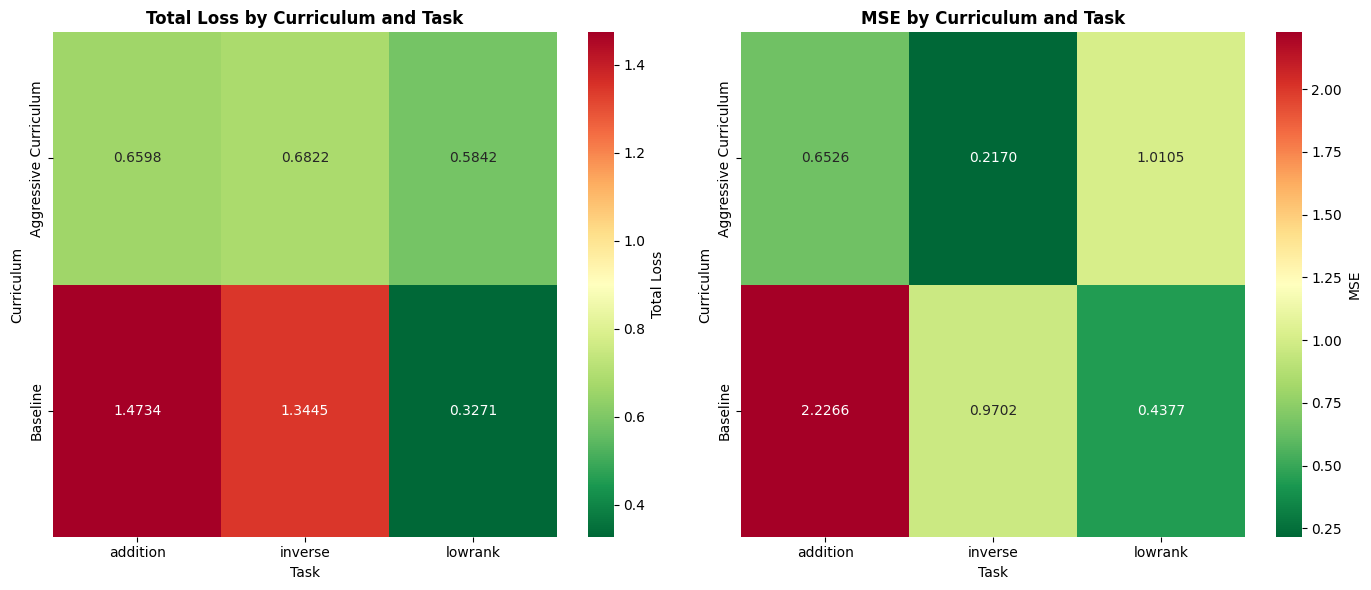

In [31]:
def visualize_task_curriculum_comparison(all_results: Dict, summary_df: pd.DataFrame, task: str):
    """Create comprehensive side-by-side curriculum comparison visualizations for a specific task."""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Multi-Curriculum Training Comparison - {task.upper()} Task', fontsize=16, fontweight='bold')

    task_results = all_results.get(task, {})
    task_summary = summary_df[summary_df['task'] == task]

    # 1. Total Loss Comparison
    ax = axes[0, 0]
    for curriculum_key, data in task_results.items():
        training_df = data.get('training')
        if training_df is not None and 'total_loss' in training_df.columns:
            config = CURRICULUM_CONFIGS[curriculum_key]
            ax.plot(training_df['step'], training_df['total_loss'],
                    color=config['color'], label=config['name'], linewidth=2, alpha=0.8)

    ax.set_title('Total Loss Curves', fontweight='bold')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Total Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # 2. Energy Loss Comparison
    ax = axes[0, 1]
    for curriculum_key, data in task_results.items():
        training_df = data.get('training')
        if training_df is not None and 'loss_energy' in training_df.columns:
            config = CURRICULUM_CONFIGS[curriculum_key]
            ax.plot(training_df['step'], training_df['loss_energy'],
                    color=config['color'], label=config['name'], linewidth=2, alpha=0.8)

    ax.set_title('Energy Loss Curves', fontweight='bold')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Energy Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Prepare colors for bar charts
    colors = task_summary['color'].tolist()

    # 3. Task-specific metric comparison
    ax = axes[1, 0]
    curricula = task_summary['name'].tolist()

    if task == 'inverse':
        # Identity Error for inverse task
        identity_errors = task_summary['final_identity_error'].tolist()
        valid_errors = [(c, e, col) for c, e, col in zip(curricula, identity_errors, colors)
                        if e != float('inf')]

        if valid_errors:
            names, errors, cols = zip(*valid_errors)
            bars = ax.bar(names, errors, color=cols, alpha=0.7, edgecolor='black')
            ax.set_title('Identity Error (Lower = Better)', fontweight='bold')
            ax.set_ylabel('||Pred @ Input - I||²')
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

            # Add value labels
            for bar, error in zip(bars, errors):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                        f'{error:.4f}', ha='center', va='bottom', fontweight='bold')
    else:
        # MAE for addition/lowrank tasks
        mae_values = task_summary['final_val_mae'].tolist()
        valid_mae = [(c, m, col) for c, m, col in zip(curricula, mae_values, colors)
                     if m != float('inf')]

        if valid_mae:
            names, maes, cols = zip(*valid_mae)
            bars = ax.bar(names, maes, color=cols, alpha=0.7, edgecolor='black')
            ax.set_title('Mean Absolute Error (Lower = Better)', fontweight='bold')
            ax.set_ylabel('MAE')
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

            # Add value labels
            for bar, mae in zip(bars, maes):
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                        f'{mae:.4f}', ha='center', va='bottom', fontweight='bold')

    # 4. MSE Comparison (common metric)
    ax = axes[1, 1]
    mse_values = task_summary['final_val_mse'].tolist()

    # Filter out inf values
    valid_mse = [(c, m, col) for c, m, col in zip(curricula, mse_values, colors)
                 if m != float('inf')]

    if valid_mse:
        names, mses, cols = zip(*valid_mse)
        bars = ax.bar(names, mses, color=cols, alpha=0.7, edgecolor='black')
        ax.set_title('Mean Squared Error', fontweight='bold')
        ax.set_ylabel('MSE')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        # Add value labels
        for bar, mse in zip(bars, mses):
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                    f'{mse:.4f}', ha='center', va='bottom', fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No validation data available\n(Run longer training for validation metrics)',
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('MSE (N/A)', fontweight='bold')

    plt.tight_layout()
    plt.show()

def visualize_cross_task_comparison(summary_df: pd.DataFrame):
    """Compare curriculum performance across different tasks."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Cross-Task Curriculum Performance Comparison', fontsize=16, fontweight='bold')

    tasks = summary_df['task'].unique()

    # Plot for each task
    for idx, task in enumerate(tasks):
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]

        task_data = summary_df[summary_df['task'] == task]

        # Create grouped bar chart for final losses
        x = np.arange(len(task_data))
        width = 0.35

        bars1 = ax.bar(x - width/2, task_data['final_total_loss'], width,
                      label='Total Loss', alpha=0.7)
        bars2 = ax.bar(x + width/2, task_data['final_val_mse'], width,
                      label='MSE', alpha=0.7)

        ax.set_title(f'{task.upper()} Task Performance', fontweight='bold')
        ax.set_ylabel('Loss/Error')
        ax.set_xticks(x)
        ax.set_xticklabels(task_data['name'], rotation=45, ha='right')
        ax.legend()
        ax.grid(True, alpha=0.3)

    # Hide unused subplots if any
    for idx in range(len(tasks), 6):
        row = idx // 3
        col = idx % 3
        fig.delaxes(axes[row, col])

    plt.tight_layout()
    plt.show()

def create_task_performance_heatmap(summary_df: pd.DataFrame):
    """Create a heatmap showing curriculum performance across tasks."""
    import seaborn as sns

    # Pivot data for heatmap
    pivot_loss = summary_df.pivot(index='name', columns='task', values='final_total_loss')
    pivot_mse = summary_df.pivot(index='name', columns='task', values='final_val_mse')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Total Loss heatmap
    sns.heatmap(pivot_loss, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax1, cbar_kws={'label': 'Total Loss'})
    ax1.set_title('Total Loss by Curriculum and Task', fontweight='bold')
    ax1.set_xlabel('Task')
    ax1.set_ylabel('Curriculum')

    # MSE heatmap
    # Replace inf values with NaN for better visualization
    pivot_mse_clean = pivot_mse.replace([float('inf')], np.nan)
    sns.heatmap(pivot_mse_clean, annot=True, fmt='.4f', cmap='RdYlGn_r', ax=ax2, cbar_kws={'label': 'MSE'})
    ax2.set_title('MSE by Curriculum and Task', fontweight='bold')
    ax2.set_xlabel('Task')
    ax2.set_ylabel('Curriculum')

    plt.tight_layout()
    plt.show()

# Generate visualizations for each task
print("Generating task-specific curriculum comparison visualizations...")
for task in TASKS:
    print(f"\nVisualizing {task.upper()} task...")
    visualize_task_curriculum_comparison(all_results, summary_df, task)

print("\nGenerating cross-task comparison...")
visualize_cross_task_comparison(summary_df)

print("\nGenerating performance heatmap...")
create_task_performance_heatmap(summary_df)

In [32]:
def generate_task_ranking(summary_df: pd.DataFrame):
    """Generate comprehensive ranking for each task and overall."""

    print("\n" + "="*80)
    print("MULTI-TASK CURRICULUM RANKING ANALYSIS")
    print("="*80)

    # Rank curricula for each task
    for task in TASKS:
        task_data = summary_df[summary_df['task'] == task].copy()

        print(f"\n📊 {task.upper()} TASK RANKING")
        print("-" * 50)

        # Create a scoring system
        task_data['score'] = 0

        # Score based on final loss (lower is better)
        loss_rank = task_data['final_total_loss'].rank()
        task_data['score'] += (len(task_data) - loss_rank + 1) * 25

        # Score based on MSE (lower is better)
        mse_valid = task_data['final_val_mse'] != float('inf')
        if mse_valid.any():
            mse_rank = task_data.loc[mse_valid, 'final_val_mse'].rank()
            task_data.loc[mse_valid, 'score'] += (len(mse_rank) - mse_rank + 1) * 25

        # Task-specific scoring
        if task == 'inverse':
            # Score based on identity error
            id_valid = task_data['final_identity_error'] != float('inf')
            if id_valid.any():
                id_rank = task_data.loc[id_valid, 'final_identity_error'].rank()
                task_data.loc[id_valid, 'score'] += (len(id_rank) - id_rank + 1) * 25
        elif task in ['addition', 'lowrank']:
            # Score based on MAE
            mae_valid = task_data['final_val_mae'] != float('inf')
            if mae_valid.any():
                mae_rank = task_data.loc[mae_valid, 'final_val_mae'].rank()
                task_data.loc[mae_valid, 'score'] += (len(mae_rank) - mae_rank + 1) * 25

        # Score based on training efficiency
        time_rank = task_data['avg_training_time'].rank()
        task_data['score'] += (len(task_data) - time_rank + 1) * 25

        # Normalize scores to 0-100
        max_score = task_data['score'].max()
        if max_score > 0:
            task_data['normalized_score'] = (task_data['score'] / max_score) * 100
        else:
            task_data['normalized_score'] = 0

        # Sort by score
        task_data = task_data.sort_values('normalized_score', ascending=False)

        # Display ranking
        rank_table = task_data[['name', 'normalized_score', 'final_total_loss', 'final_val_mse']].copy()
        rank_table['rank'] = range(1, len(rank_table) + 1)
        rank_table = rank_table[['rank', 'name', 'normalized_score', 'final_total_loss', 'final_val_mse']]
        rank_table.columns = ['Rank', 'Curriculum', 'Score', 'Final Loss', 'MSE']

        print(rank_table.round(2).to_string(index=False))

        # Winner for this task
        winner = task_data.iloc[0]
        print(f"\n🏆 Winner for {task.upper()}: {winner['name']} (Score: {winner['normalized_score']:.1f})")

        # Check if curriculum beats baseline
        baseline_score = task_data[task_data['curriculum'] == 'baseline']['normalized_score'].values
        if len(baseline_score) > 0 and winner['curriculum'] != 'baseline':
            improvement = winner['normalized_score'] - baseline_score[0]
            print(f"   Improvement over baseline: +{improvement:.1f} points")

    # Overall ranking across all tasks
    print("\n" + "="*60)
    print("📈 OVERALL CROSS-TASK RANKING")
    print("="*60)

    # Calculate average score across tasks for each curriculum
    overall_scores = []
    for curriculum_key in CURRICULUM_CONFIGS.keys():
        curriculum_data = summary_df[summary_df['curriculum'] == curriculum_key]

        if len(curriculum_data) > 0:
            # Calculate average performance metrics
            avg_loss = curriculum_data['final_total_loss'].mean()
            avg_mse = curriculum_data[curriculum_data['final_val_mse'] != float('inf')]['final_val_mse'].mean()
            avg_time = curriculum_data['avg_training_time'].mean()

            overall_scores.append({
                'curriculum': curriculum_key,
                'name': CURRICULUM_CONFIGS[curriculum_key]['name'],
                'avg_loss': avg_loss,
                'avg_mse': avg_mse if not np.isnan(avg_mse) else float('inf'),
                'avg_time': avg_time,
                'num_tasks': len(curriculum_data)
            })

    overall_df = pd.DataFrame(overall_scores)

    # Rank based on average loss
    overall_df['rank'] = overall_df['avg_loss'].rank().astype(int)
    overall_df = overall_df.sort_values('rank')

    print("\nOverall Performance Across All Tasks:")
    display_df = overall_df[['rank', 'name', 'avg_loss', 'avg_mse', 'avg_time']].copy()
    display_df.columns = ['Rank', 'Curriculum', 'Avg Loss', 'Avg MSE', 'Avg Time']
    print(display_df.round(4).to_string(index=False))

    print("\n🎯 KEY FINDINGS:")
    overall_winner = overall_df.iloc[0]
    print(f"   • Best Overall: {overall_winner['name']}")
    print(f"   • Average Loss: {overall_winner['avg_loss']:.4f}")

    # Check curriculum vs baseline
    baseline_overall = overall_df[overall_df['curriculum'] == 'baseline']
    if len(baseline_overall) > 0:
        baseline_loss = baseline_overall['avg_loss'].iloc[0]
        if overall_winner['curriculum'] != 'baseline':
            improvement = (baseline_loss - overall_winner['avg_loss']) / baseline_loss * 100
            print(f"   • Improvement over baseline: {improvement:.1f}%")
        else:
            print("   • Baseline performed best overall")

    return overall_df

# Generate comprehensive ranking
print("Generating multi-task ranking analysis...")
overall_ranking = generate_task_ranking(summary_df)

Generating multi-task ranking analysis...

MULTI-TASK CURRICULUM RANKING ANALYSIS

📊 INVERSE TASK RANKING
--------------------------------------------------
 Rank            Curriculum  Score  Final Loss  MSE
    1 Aggressive Curriculum  100.0        0.68 0.22
    2              Baseline   50.0        1.34 0.97

🏆 Winner for INVERSE: Aggressive Curriculum (Score: 100.0)
   Improvement over baseline: +50.0 points

📊 ADDITION TASK RANKING
--------------------------------------------------
 Rank            Curriculum  Score  Final Loss  MSE
    1 Aggressive Curriculum  100.0        0.66 0.65
    2              Baseline   50.0        1.47 2.23

🏆 Winner for ADDITION: Aggressive Curriculum (Score: 100.0)
   Improvement over baseline: +50.0 points

📊 LOWRANK TASK RANKING
--------------------------------------------------
 Rank            Curriculum  Score  Final Loss  MSE
    1              Baseline  100.0        0.33 0.44
    2 Aggressive Curriculum   80.0        0.58 1.01

🏆 Winner for LOW

## Multi-Task Summary Analysis and Ranking

In [33]:
# Save comprehensive results
output_dir = Path('./multi_task_curriculum_results')
output_dir.mkdir(exist_ok=True)

# Export summary data
summary_df.to_csv(output_dir / 'multi_task_curriculum_summary.csv', index=False)
overall_ranking.to_csv(output_dir / 'overall_curriculum_ranking.csv', index=False)

# Create task-specific summaries
for task in TASKS:
    task_data = summary_df[summary_df['task'] == task]
    task_data.to_csv(output_dir / f'{task}_curriculum_summary.csv', index=False)

print("\n" + "="*80)
print("MULTI-TASK CURRICULUM TRAINING - FINAL REPORT")
print("="*80)

print(f"\n📁 Results saved to: {output_dir}")
print("   • multi_task_curriculum_summary.csv - All results across tasks")
print("   • overall_curriculum_ranking.csv - Overall curriculum rankings")
for task in TASKS:
    print(f"   • {task}_curriculum_summary.csv - {task.capitalize()} task specific results")

# Training statistics
total_configs = len(CURRICULUM_CONFIGS) * len(TASKS)
successful_runs = sum(1 for _, task_results in training_results.items()
                     for result in task_results.values() if result == 0)

print(f"\n📊 TRAINING STATISTICS:")
print(f"   • Total configurations tested: {total_configs}")
print(f"   • Successful runs: {successful_runs}/{total_configs}")
print(f"   • Tasks evaluated: {', '.join(TASKS)}")
print(f"   • Curricula tested: {', '.join([cfg['name'] for cfg in CURRICULUM_CONFIGS.values()])}")

print("\n🏆 EXECUTIVE SUMMARY:")
print(f"   • Best Overall Curriculum: {overall_ranking.iloc[0]['name']}")
print(f"   • Training steps per run: {COMMON_ARGS['train_num_steps']}")
print(f"   • CSV logging interval: {COMMON_ARGS['csv_log_interval']} steps")

# Task-specific winners
print("\n🎯 TASK-SPECIFIC WINNERS:")
for task in TASKS:
    task_data = summary_df[summary_df['task'] == task]
    if len(task_data) > 0:
        # Find best by loss
        best_idx = task_data['final_total_loss'].idxmin()
        winner = task_data.loc[best_idx]
        print(f"   • {task.upper()}: {winner['name']} (Loss: {winner['final_total_loss']:.4f})")

print("\n" + "="*80)
print("🚀 MULTI-TASK MULTI-CURRICULUM SMOKE TEST COMPLETED! 🚀")
print("="*80)
print("\nUse the generated CSV files and visualizations to:")
print("1. Select the best curriculum approach for each task")
print("2. Compare baseline vs curriculum learning effectiveness")
print("3. Understand trade-offs between different curriculum strategies")
print("4. Make informed decisions for production training")


MULTI-TASK CURRICULUM TRAINING - FINAL REPORT

📁 Results saved to: multi_task_curriculum_results
   • multi_task_curriculum_summary.csv - All results across tasks
   • overall_curriculum_ranking.csv - Overall curriculum rankings
   • inverse_curriculum_summary.csv - Inverse task specific results
   • addition_curriculum_summary.csv - Addition task specific results
   • lowrank_curriculum_summary.csv - Lowrank task specific results

📊 TRAINING STATISTICS:
   • Total configurations tested: 6
   • Successful runs: 6/6
   • Tasks evaluated: inverse, addition, lowrank
   • Curricula tested: Baseline, Aggressive Curriculum

🏆 EXECUTIVE SUMMARY:
   • Best Overall Curriculum: Aggressive Curriculum
   • Training steps per run: 20000
   • CSV logging interval: 100 steps

🎯 TASK-SPECIFIC WINNERS:
   • INVERSE: Aggressive Curriculum (Loss: 0.6822)
   • ADDITION: Aggressive Curriculum (Loss: 0.6598)
   • LOWRANK: Baseline (Loss: 0.3271)

🚀 MULTI-TASK MULTI-CURRICULUM SMOKE TEST COMPLETED! 🚀

Use t